# Trabajo Practico 3 - Finanzas Computacionales (UdeSA)
## Bautista Remondino - Santiago Pini - Pedro Gallo - Ignacio Bidarte


# Ejercicio 1

Empezamos con el metodo explicito, este primer bloque muestra se configuro la grilla de $x$ e $y$, $\Delta \tau$ y $\lambda$ estable


In [14]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Parámetros del problema
K = 100.0
r = 0.05
sigma = 0.20
T = 1.0

grilla_x = np.linspace(10, 200, 100)
grilla_t = np.linspace(0, T, 100)

S_min, S_max = 0.1*K, 4.0*K  
x_min, x_max = np.log(S_min), np.log(S_max)

Nx  = 400                              # num de intervalos en x
dx  = (x_max - x_min)/Nx
x   = np.linspace(x_min, x_max, Nx+1)

tau_max = 0.5 * sigma**2 * T

# Para el EXPÍCITO necesito λ = Δτ / (Δx)^2 ≤ 0.5  → elijo λ=0.45
lam   = 0.45
dtau  = lam * dx**2
Nt    = int(np.ceil(tau_max / dtau))   # cantidad de pasos de tiempo
dtau  = tau_max / Nt                   
lam   = dtau / dx**2                   # λ final (≤ 0.5 garantizado)
tau   = np.linspace(0.0, tau_max, Nt+1)


### Condiciones iniciales y de frontera

In [15]:
# Condición inicial: valor de la opción al vencimiento (t=T, τ=0)
y = np.exp(-r*T) * np.maximum(np.exp(x) - K, 0)

# Condición de frontera izquierda: S → 0  (x → -∞ o x_min)
# Notamos que es una frontera constante, no depende del tiempo por lo cual la podemos dejar fija.
def frontera_izquierda(tau):
    return 0.0

# Condición de frontera derecha: S → ∞  (x → +∞ o x_max)
def frontera_derecha(tau):
    return ( np.exp( -r*(T - 2.0*tau/sigma**2) )
             * np.exp( x_max - (2.0*r/sigma**2 - 1.0)*tau )
             - K * np.exp(-r*T) )


### Metodo explícito

Partimos de la ecuación del calor:

$$
\frac{\partial y}{\partial t} = \frac{\partial^2 y}{\partial x^2}
$$

Reemplazando por derivadas centrada y adelantada:

$$
\frac{y(x,t+1) - y(x,t)}{\Delta t} = \frac{y(x+1,t) - 2y(x,t) + y(x-1,t)}{\Delta x^2}
$$

Buscamos aislar $ y(x,t+1) $, por tanto multiplicamos a ambos lados $\Delta t$:

$$
y(x,t+1) - y(x,t) = \frac{\Delta t}{\Delta x^2} \left[ y(x+1,t) - 2y(x,t) + y(x-1,t) \right]
$$

Definimos $ \lambda = \frac{\Delta t}{\Delta x^2} $, entonces:

$$
y(x,t+1) = y(x,t) + \lambda \left[ y(x+1,t) - 2y(x,t) + y(x-1,t) \right]
$$

$$
y(x,t+1) = \lambda y(x+1,t) + (1+2\lambda) y(x,t) + \lambda y(x-1,t) 
$$

In [4]:
for n in range(Nt):
    y_new = y.copy()
    y_new[1:-1] = y[1:-1] + lam * (y[2:] - 2*y[1:-1] + y[:-2])
    # fronteras
    y_new[0]  = frontera_izquierda(tau[n+1])
    y_new[-1] = frontera_derecha(tau[n+1])
    y = y_new


# Tomamos un precio en especial y chequeamos el resultado numérico

shift = (2.0*r/sigma**2 - 1.0) * tau_max
S_grid = np.exp( x - shift )          # mapea x → S en t=0
V_num = y                             # en t=0 el factor exponencial es 1, luego V = y

S0 = K
idx = np.argmin( np.abs(S_grid - S0) )
V_S0 = V_num[idx]
print(f"Precio numérico explícito para S0={S0}, t=0: {V_S0}")

Precio numérico explícito para S0=100.0, t=0: 10.49231204305964


### Metodo Implícito

Nuevamente partimos de la ecuación del calor:

$$
\frac{\partial y}{\partial t} = \frac{\partial^2 y}{\partial x^2}
$$

Reemplazando por derivadas centrada y adelantada:

$$
\frac{y(x,t+1) - y(x,t)}{\Delta t} = \frac{y(x+1,t+1) - 2y(x,t+1) + y(x-1,t+1)}{\Delta x^2}
$$

Multiplicamos por $\Delta t$ y mandamos todos los terminos con $t+1$ para el otro lado:

$$
y(x,t+1) - y(x,t) = \frac{\Delta t}{\Delta x^2} \left[ y(x+1,t+1) - 2y(x,t+1) + y(x-1,t+1) \right]
$$

Definimos $ \lambda = \frac{\Delta t}{\Delta x^2} $, entonces:

$$
y(x,t) = y(x,t+1) - \lambda \left[ y(x+1,t+1) - 2y(x,t+1) + y(x-1,t+1) \right]
$$

$$
y(x,t) = - \lambda y(x+1,t+1) + (1+2\lambda) y(x,t+1) - \lambda y(x-1,t+1)
$$

### Matricialmente podriamos pensar este problema como:

Si definís el vector de incógnitas en los puntos interiores del dominio espacial:


$$
\mathbf{y(x,t+1)} =
\begin{bmatrix}
y(x,t+1) \\
y(x+1,t+1) \\
\vdots \\
y(N-1, t+1)
\end{bmatrix},
\quad
\mathbf{y(x,t)} =
\begin{bmatrix}
y(x,t) \\
y(x+1,t) \\
\vdots \\
y(N-1, t)
\end{bmatrix}.
$$


Entonces, el sistema de ecuaciones del método implícito se puede escribir como:

$$
A\,y(x, t + 1) = y(x, t) + d(x, t),
$$

donde la matriz \(A\) tiene estructura tridiagonal:

$$
A =
\begin{bmatrix}
1 + 2\lambda & -\lambda & 0 & \dots & 0 \\
-\lambda & 1 + 2\lambda & -\lambda & \ddots & \vdots \\
0 & \ddots & \ddots & \ddots & 0 \\
\vdots & \ddots & -\lambda & 1 + 2\lambda & -\lambda \\
0 & \dots & 0 & -\lambda & 1 + 2\lambda
\end{bmatrix}
\in \mathbb{R}^{(N-1)\times(N-1)}.
$$

y el vector \(d(x,t)\) incorpora las condiciones de frontera que entran solo en la primera y última ecuación interior:


$$
\mathbf{d}^{\,n+1} =
\begin{bmatrix}
\lambda\,y(0,t+1) \\
0 \\
\vdots \\
0 \\
\lambda\,y(N,n-1)
\end{bmatrix}.
$$

### Armado de la matriz A
Se reutilizan las condiciones iniciales y de frontera, como tambien las variables de $\Delta \tau$, la grilla de $x$ e $y$, etc.

In [12]:
main_diag = (1 + 2*lam) * np.ones(Nx-1) #vector con la diagonal principal
off_diag  = -lam * np.ones(Nx-2)         #vector con las diagonales secundarias de tamaño n-2
A = np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1) #compila las diagolanales en una matriz


for n in range(Nt):
    yL = frontera_izquierda(tau[n+1])  
    yR = frontera_derecha(tau[n+1])    

    # Construimos el vector d del lado derecho
    d = np.zeros(Nx-1)
    d[0]  = lam * yL
    d[-1] = lam * yR

    rhs = y[1:-1] + d
    y_interior = np.linalg.solve(A, rhs) # Resolvemos el sistema lineal usando metodos de Numpy que son menos costosos computacionalmente que aplicar la inversa directamente

    # Actualizamos el vector completo
    y[0]      = yL
    y[1:-1]   = y_interior
    y[-1]     = yR


# Mismo metodo que en el explícito para obtener el precio en S0=K

shift = (2.0*r/sigma**2 - 1.0) * tau_max   # tau_max = (σ²/2)T
S_grid = np.exp(x - shift)                  # S asociado a cada nodo x en t=0

# y contiene la solución final en τ=τ_max (t=0)
V_num = y.copy()                            # V(S,0) = y(x, τ_max)

S0 = K
idx = np.argmin(np.abs(S_grid - S0))
V_S0_nearest = V_num[idx]
print(f"[Implícito] Precio numérico (nearest) para S0={S0}: {V_S0_nearest:.6f}")

[Implícito] Precio numérico (nearest) para S0=100.0: 10.488893


### Metodo de Crank-Nicolson
Consiste en tomar un promedio de ambos esquemas (implícito y explícito):

$$
\frac{\partial y}{\partial t} = \frac{\partial^2 y}{\partial x^2}
$$

$$
\frac{y(x,t+1) - y(x,t)}{\Delta t} = \frac{1}{2\Delta x^2} \left[ [ y(x+1,t) - 2y(x,t) + y(x-1,t) ] + [ y(x+1, t+1) - 2y(x,t+1) + y(x-1,t+1)] \right ]
$$

Pasamos el $\Delta \tau$ del otro lado:

$$
\frac{y(x,t+1) - y(x,t)}{\Delta t} = \frac{1}{2\Delta x^2} \left[ [ y(x+1,t) - 2y(x,t) + y(x-1,t) ] + [ y(x+1, t+1) - 2y(x,t+1) + y(x-1,t+1)] \right ]
$$

$$
y(x,t+1) - y(x,t) = \frac{\Delta \tau}{2\Delta x^2} \left[ [ y(x+1,t) - 2y(x,t) + y(x-1,t) ] + [ y(x+1, t+1) - 2y(x,t+1) + y(x-1,t+1)] \right ]
$$

Conocemos la definición de $\lambda$:

$$
y(x,t+1) - y(x,t) = \lambda \left[ [ y(x+1,t) - 2y(x,t) + y(x-1,t) ] + [ y(x+1, t+1) - 2y(x,t+1) + y(x-1,t+1)] \right ]
$$

Despejamos de un lado los $t+1$ y finalmente nos queda:

$$
\frac{-\lambda}{2} y(x-1,t+1) + (1+\lambda) y(x,t+1) - \frac{-\lambda}{2} y(x+1,t+1) = \frac{\lambda}{2} y(x-1,t) + (1-\lambda) y(x,t) + \frac{\lambda}{2}y(x+1,t)
$$

Matricialmente esto lo podemos pensar como:

$$
A\,y^{n+1} = B\,y^{n} + d,
$$

donde:

$$
A =
\begin{bmatrix}
1 + \lambda & -\frac{\lambda}{2} & 0 & \dots & 0 \\
-\frac{\lambda}{2} & 1 + \lambda & -\frac{\lambda}{2} & \ddots & \vdots \\
0 & \ddots & \ddots & \ddots & 0 \\
\vdots & \ddots & -\frac{\lambda}{2} & 1 + \lambda & -\frac{\lambda}{2} \\
0 & \dots & 0 & -\frac{\lambda}{2} & 1 + \lambda
\end{bmatrix},
$$

$$
B =
\begin{bmatrix}
1 - \lambda & \frac{\lambda}{2} & 0 & \dots & 0 \\
\frac{\lambda}{2} & 1 - \lambda & \frac{\lambda}{2} & \ddots & \vdots \\
0 & \ddots & \ddots & \ddots & 0 \\
\vdots & \ddots & \frac{\lambda}{2} & 1 - \lambda & \frac{\lambda}{2} \\
0 & \dots & 0 & \frac{\lambda}{2} & 1 - \lambda
\end{bmatrix},
$$

$$
d = \frac{\lambda}{2}
\begin{bmatrix}
y_0^{n+1} + y_0^{n} \\
0 \\
\vdots \\
0 \\
y_{N_x}^{n+1} + y_{N_x}^{n}
\end{bmatrix}.
$$

In [16]:
N = Nx 

# Armado de matrices A y B

main_A = (1.0 + lam)   * np.ones(N-1)
off_A  = (-0.5 * lam)  * np.ones(N-2)
A_CN   = np.diag(main_A) + np.diag(off_A, 1) + np.diag(off_A, -1)

main_B = (1.0 - lam)   * np.ones(N-1)
off_B  = ( 0.5 * lam)  * np.ones(N-2)
B_CN   = np.diag(main_B) + np.diag(off_B, 1) + np.diag(off_B, -1)

for n in range(Nt):
    # Fronteras en tiempos n y n+1
    yL_n   = frontera_izquierda(tau[n])
    yR_n   = frontera_derecha(tau[n])
    yL_np1 = frontera_izquierda(tau[n+1])
    yR_np1 = frontera_derecha(tau[n+1])

    # Lado derecho
    y_int_n = y[1:-1].copy()               
    rhs = B_CN @ y_int_n 

    # vector de borde (solo extremos interior)
    rhs[0]  += 0.5 * lam * (yL_n   + yL_np1)
    rhs[-1] += 0.5 * lam * (yR_n   + yR_np1)

    # Nuevamente usamos el metodo de numpy para resolver el sistema lineal
    y_int_np1 = np.linalg.solve(A_CN, rhs)

    # Reconstruir solución completa en n+1
    y[0]      = yL_np1
    y[1:-1]   = y_int_np1
    y[-1]     = yR_np1

# Nuevamente usamos el metodo de comparación con el valor exacto para S0=K como en el explícito e implícito.

shift = (2.0*r/sigma**2 - 1.0) * tau_max
S_grid = np.exp(x - shift)
V_num = y.copy()  # en t=0, V(S,0) = y(x, τ_max)
S0 = K
idx = np.argmin(np.abs(S_grid - S0))
V_S0_nearest = V_num[idx]
print(f"[Crank–Nicolson] Precio numérico para S0={S0}: {V_S0_nearest:.6f}")

[Crank–Nicolson] Precio numérico para S0=100.0: 10.490603


### Chequeo con un función de una librería

In [26]:
from py_vollib.black_scholes import black_scholes
from py_vollib.black_scholes.greeks.analytical import delta, gamma, vega, theta

S = 100
K = 100
r = 0.05
sigma = 0.20
t = 1.0
flag = 'c'   # 'c' para call, 'p' para put

price = black_scholes(flag, S, K, t, r, sigma)
print("Precio B-S:", price)
print("Delta:", delta(flag, S, K, t, r, sigma))
print("Gamma:", gamma(flag, S, K, t, r, sigma))

Precio B-S: 10.450583572185561
Delta: 0.6368306511756191
Gamma: 0.018762017345846895


# Ejercicio 2)


--- Resultado final (esquema = cn) ---
Longitud grilla: 401 puntos.
Precio numérico en S0=100.0, t=0 ≈ 10.450869

Primeros 10 pares (S, V(S,0)):
S=   9.704  V=  0.000000
S=  14.034  V=  0.000000
S=  20.295  V=  0.000000
S=  29.349  V=  0.000000
S=  42.442  V=  0.000080
S=  61.376  V=  0.076631
S=  88.758  V=  4.574150
S= 128.355  V= 33.880562
S= 185.618  V= 90.497582
S= 268.426  V=173.303453
S= 388.178  V=293.055271


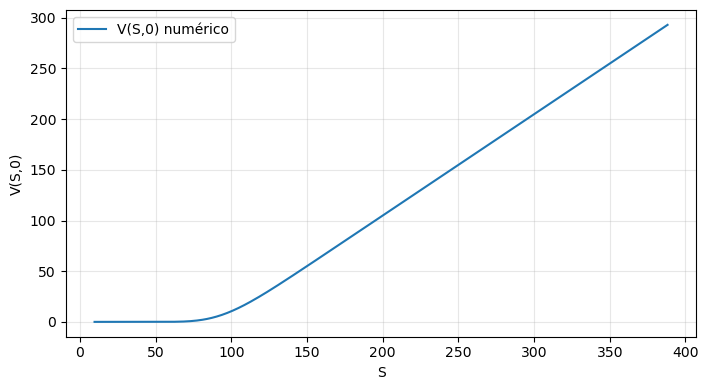

In [6]:
# %% ------------------------------------------------------------
# Retransformación V(S,t) desde la ecuación del calor
# Solo devuelve V(S,0) y la grilla S (sin gráficos)
# ------------------------------------------------------------

import numpy as np
import math

# ========= PARÁMETROS =========
K = 100.0
r = 0.05
sigma = 0.20
T = 1.0
option = 'call'     # 'call' o 'put'
scheme = 'cn'       # 'explicit' | 'implicit' | 'cn'

# Dominio
S_min_solve, S_max_solve = 0.1*K, 4.0*K
x_min, x_max = np.log(S_min_solve), np.log(S_max_solve)
Nx  = 400
dx  = (x_max - x_min)/Nx
x   = np.linspace(x_min, x_max, Nx+1)
tau_max = 0.5 * sigma**2 * T

# malla temporal
lam   = 0.45
dtau  = lam * dx**2
Nt    = int(np.ceil(tau_max / dtau))
dtau  = tau_max / Nt
lam   = dtau / dx**2
tau   = np.linspace(0.0, tau_max, Nt+1)

# ========= UTILIDADES =========
def payoff(S):
    if option == 'call':
        return np.maximum(S - K, 0.0)
    else:
        return np.maximum(K - S, 0.0)

def condicion_inicial(x_vec):
    return np.exp(-r*T) * payoff(np.exp(x_vec))

def frontera_izquierda(tau_):
    if option == 'call':
        return 0.0
    else:
        return np.exp(-r*T) * (K - np.exp(x_min + tau_))

def frontera_derecha(tau_):
    if option == 'call':
        return np.exp(-r*T) * (np.exp(x_max + tau_) - K)
    else:
        return 0.0

def bs_price(S, K, r, sigma, T, flag='call'):
    from math import log, sqrt, exp, erf
    def N(z): return 0.5*(1+erf(z/np.sqrt(2)))
    if T <= 0: return max(S-K,0) if flag=='call' else max(K-S,0)
    d1 = (log(S/K)+(r+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    if flag=='call':
        return S*N(d1)-K*exp(-r*T)*N(d2)
    else:
        return K*exp(-r*T)*N(-d2)-S*N(-d1)

# ========= SOLUTORES =========
def solve_explicito(x, tau, lam):
    if lam > 0.5 + 1e-12:
        raise ValueError(f"Explícito inestable: λ={lam:.4f}>0.5")
    Nx1, Nt1 = len(x), len(tau)
    Y = np.zeros((Nt1, Nx1))
    y = condicion_inicial(x)
    Y[0,:] = y
    for n in range(Nt1-1):
        y_new = y.copy()
        y_new[1:-1] = y[1:-1] + lam*(y[2:] - 2*y[1:-1] + y[:-2])
        y_new[0]  = frontera_izquierda(tau[n+1])
        y_new[-1] = frontera_derecha(tau[n+1])
        y = y_new
        Y[n+1,:] = y
    return Y

def solve_implicito(x, tau, lam):
    Nx1, Nt1 = len(x), len(tau)
    Y = np.zeros((Nt1, Nx1))
    y = condicion_inicial(x)
    Y[0,:] = y
    Nint = Nx1-1
    main = (1 + 2*lam) * np.ones(Nint-1)
    off  = (-lam)      * np.ones(Nint-2)
    A = np.diag(main) + np.diag(off, 1) + np.diag(off, -1)
    for n in range(Nt1-1):
        yL = frontera_izquierda(tau[n+1])
        yR = frontera_derecha(tau[n+1])
        rhs = y[1:-1].copy()
        rhs[0]  += lam * yL
        rhs[-1] += lam * yR
        y_int = np.linalg.solve(A, rhs)
        y[0], y[1:-1], y[-1] = yL, y_int, yR
        Y[n+1,:] = y
    return Y

def solve_crank_nicolson(x, tau, lam):
    Nx1, Nt1 = len(x), len(tau)
    Y = np.zeros((Nt1, Nx1))
    y = condicion_inicial(x)
    Y[0,:] = y
    Nint = Nx1-1
    main_A = (1.0 + lam)  * np.ones(Nint-1)
    off_A  = (-0.5*lam)   * np.ones(Nint-2)
    A = np.diag(main_A) + np.diag(off_A, 1) + np.diag(off_A, -1)
    main_B = (1.0 - lam)  * np.ones(Nint-1)
    off_B  = ( 0.5*lam)   * np.ones(Nint-2)
    B = np.diag(main_B) + np.diag(off_B, 1) + np.diag(off_B, -1)
    for n in range(Nt1-1):
        yL_n,  yR_n  = frontera_izquierda(tau[n]),   frontera_derecha(tau[n])
        yL_np, yR_np = frontera_izquierda(tau[n+1]), frontera_derecha(tau[n+1])
        rhs = B @ y[1:-1]
        rhs[0]  += 0.5*lam*(yL_n + yL_np)
        rhs[-1] += 0.5*lam*(yR_n + yR_np)
        y_int = np.linalg.solve(A, rhs)
        y[0], y[1:-1], y[-1] = yL_np, y_int, yR_np
        Y[n+1,:] = y
    return Y

# ========= ELEGIR ESQUEMA Y RESOLVER =========
if scheme == 'explicit':
    Y = solve_explicito(x, tau, lam)
elif scheme == 'implicit':
    Y = solve_implicito(x, tau, lam)
elif scheme in ('cn', 'crank', 'crank-nicolson'):
    Y = solve_crank_nicolson(x, tau, lam)
else:
    raise ValueError("scheme debe ser 'explicit', 'implicit' o 'cn'")

# ========= RETRANSFORMACIÓN (solo V(S,0)) =========
# 1) Grilla S y factor de retransformación
tau_final = tau[-1]
S_grid = np.exp(x - ((2*r/sigma**2) - 1.0)*tau_final)
factor = np.exp(r*(T - 2*tau_final/sigma**2))

# 2) Recuperar V(S,0)
V_S0 = factor * Y[-1,:]

# ========= SALIDA =========
# Ordenamos por S ascendente y devolvemos ambos vectores
order = np.argsort(S_grid)
S_sorted = S_grid[order]
V_sorted = V_S0[order]

print(f"\n--- Resultado final (esquema = {scheme}) ---")
print(f"Longitud grilla: {len(S_sorted)} puntos.")
print(f"Precio numérico en S0={K}, t=0 ≈ "
      f"{np.interp(K, S_sorted, V_sorted):.6f}")
print("\nPrimeros 10 pares (S, V(S,0)):")
for i in range(0, len(S_sorted), len(S_sorted)//10):
    print(f"S={S_sorted[i]:8.3f}  V={V_sorted[i]:10.6f}")

# devuelve también los arrays (útil en notebooks)
S_sorted, V_sorted

# --- GRAFICAR SOLO LA CURVA V(S,0) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(7.2,4.0))
plt.plot(S_sorted, V_sorted, label='V(S,0) numérico')
plt.xlabel('S')
plt.ylabel('V(S,0)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

